In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn import mixture


from sklearn.externals import joblib


import collections

from dask.distributed import Client, progress




In [11]:
# Remove the outliers
def remove_outliers(file_path):
    # return the list of dataframes
    dataframe_lists = []
    # Creating the dataframe and selecting the required columns
    for i in range(64):
        df = pd.read_csv(file_path, usecols=[1,2,3,4], skiprows=i*72000, nrows = 72000, names=["lz","X","Y","Z"])
        df['radiusSquare'] = df['X']*df['X']+df['Y']*df['Y']+df['Z']*df['Z']
        df['radius'] = np.sqrt(df['radiusSquare']).round(1)
        df['freq'] = df.groupby(['lz','radius'])['radius'].transform('count')
        for j in range(64):
            maxfreq = df[(df['lz']==j) & (df['radius']!=0)]['freq'].max()
            while maxfreq>100:
                df.drop(df[(df['lz']==j) & (df['freq']==maxfreq)].index, inplace=True)
                maxfreq = df[(df['lz']==j) & (df['radius']!=0)]['freq'].max()
                df.drop(df[(df['lz']==j) & (df['radius']==0)].index, inplace=True)
        dataframe_lists.append(df.iloc[:,1:4])
    return dataframe_lists

In [12]:
# atm = remove_outliers("/home/kia/Collected-Datasets/DEBS2019/debs2019_initial_dataset/Atm/in.csv")

# This the second data set that contains multiple objects
allData= remove_outliers("/home/kia/Collected-Datasets/DEBS2019/debs2019_dataset2/in.csv")


mX=np.array(allData[0]['X'])
mY=np.array(allData[0]['Y'])
mZ=np.array(allData[0]['Z'])




In [13]:
def removeNoise(x, y, z, rate=1.5):
    
    # We hash on x^4 + y^2, so that we can have unique hash for each tuple.  
    hashedData = np.array(list(map(hash, x.astype(np.int32)**4+ y.astype(np.int32)**2  )))

    # https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
    countsDict=collections.Counter(hashedData)


    values1 = np.fromiter(countsDict.values(), dtype=int)
    # Remove all of the data that is smaller than mean. 
    # threshold=np.mean(values1)
    threshold=np.median(values1)


    finalX=np.array([])
    finalY=np.array([])
    finalZ=np.array([])

    for i in range(x.size):
        hashKey = hash(int(x[i])**4 + int(y[i])**2)
        if(hashKey in countsDict):
            if(countsDict[hashKey] > threshold * rate):
                finalX= np.append(finalX, x[i])
                finalY= np.append(finalY, y[i])
                finalZ= np.append(finalY, z[i])
        
    return  finalX, finalY, finalZ

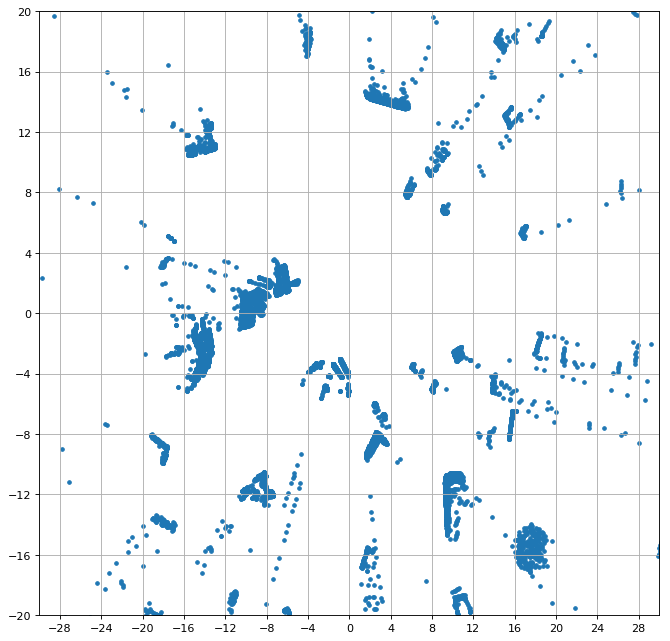

In [14]:
grid_size= 4
#fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(10, 10), dpi= 80)
ax = fig.gca()

ax.set_xticks(np.arange(-120, 120, grid_size))
ax.set_yticks(np.arange(-120, 120, grid_size))

plt.scatter(mZ, mX, s=10)
plt.xlim(-30, 30)
plt.ylim(-20, 20)
plt.grid()
plt.show()

In [15]:
def isInt(value):
    try:
        int(value)
        return True
    except:
        return False


numOfObjects = []

# Out put data.
# We need to get the number of objects. 
pathOutput="/home/kia/Collected-Datasets/DEBS2019/debs2019_dataset2/out.csv"

with open(pathOutput) as fp:  
   line = fp.readline()
   cnt = 1
   while line:
    # print("Line {}: {}".format(cnt, line.strip()))
        lineArr=line.split(",")
        num = 0
        for index in range(1, len(lineArr)):
            if(isInt(lineArr[index])):
               num +=int(lineArr[index])
        numOfObjects.append(num)
        #print(line.split(",")[1])
        line = fp.readline()
        cnt += 1
        
        
        
print(max(numOfObjects))

aList=np.array(numOfObjects)
print(np.mean(aList))
print(np.median(aList))

50
29.186
29.0


In [16]:
# clustering with DBSCAN 
def doClusteringWithDBSCAN(data, eps=1, min_samples=20):
    
    clustering = DBSCAN(eps, min_samples).fit(data)

    labels = clustering.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    return n_clusters_

In [29]:
# clustering with DBSCAN 
def doClusteringWithMeanShift(data, bandwidth=2):
    
    # client = Client(processes=False, threads_per_worker=4, n_workers=2, memory_limit='2GB')
    
    model = MeanShift(bandwidth=2, bin_seeding=True, cluster_all=False, min_bin_freq=19,
     n_jobs=None, seeds=None)
    
        
    #with joblib.parallel_backend('dask'):
    clustering=model.fit(data)

    labels = clustering.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    return n_clusters_

In [31]:
# run a test. 
sum = 0 
for i in range(64):
    
    # a first noise reduction. 
    newZ1, newX1 , newY1= removeNoise(np.array(allData[i]['Z']), np.array(allData[i]['X']), np.array(allData[i]['Y']), rate=1)

    # a second time noise reduction. 
    newZ, newX, newY = removeNoise(newZ1, newX1, newY1, rate=1)

    data =  np.array(list(zip(newX1, newY1, newZ1)))

    # numberOfClusters = doClusteringWithDBSCAN(data, eps=1, min_samples=20)
    numberOfClusters = doClusteringWithMeanShift(data, bandwidth=2)
    print(i, " Number Of Clusters: ", numberOfClusters, ", Difference is: ", numOfObjects[i] - numberOfClusters)
    sum = sum + (abs(numOfObjects[i] - numberOfClusters))

print("Sum of the Squares", sum)

0  Number Of Clusters:  34 , Difference is:  -1
1  Number Of Clusters:  27 , Difference is:  -2
2  Number Of Clusters:  27 , Difference is:  -2
3  Number Of Clusters:  15 , Difference is:  2
4  Number Of Clusters:  18 , Difference is:  -2
5  Number Of Clusters:  34 , Difference is:  0
6  Number Of Clusters:  30 , Difference is:  5
7  Number Of Clusters:  22 , Difference is:  -2
8  Number Of Clusters:  17 , Difference is:  0
9  Number Of Clusters:  32 , Difference is:  0
10  Number Of Clusters:  39 , Difference is:  0
11  Number Of Clusters:  45 , Difference is:  2
12  Number Of Clusters:  35 , Difference is:  5
13  Number Of Clusters:  12 , Difference is:  0
14  Number Of Clusters:  18 , Difference is:  1
15  Number Of Clusters:  31 , Difference is:  -5
16  Number Of Clusters:  17 , Difference is:  -1
17  Number Of Clusters:  29 , Difference is:  1
18  Number Of Clusters:  31 , Difference is:  -3
19  Number Of Clusters:  43 , Difference is:  2
20  Number Of Clusters:  25 , Difference i

In [20]:
# run a test. 
sum = 0 
for i in range(64):
    
    # a first noise reduction. 
    newZ1, newX1 , newY1= removeNoise(np.array(allData[i]['Z']), np.array(allData[i]['X']), np.array(allData[i]['Y']), rate=1)

    # a second time noise reduction. 
    newZ, newX, newY = removeNoise(newZ1, newX1, newY1, rate=1)

    data =  np.array(list(zip(newX1, newY1, newZ1)))

    numberOfClusters = doClusteringWithDBSCAN(data, eps=1, min_samples=20)
    # numberOfClusters = MeanShift(data, eps=1, min_samples=20)
    print(i, " Number Of Clusters: ", numberOfClusters, ", Difference is: ", numOfObjects[i] - numberOfClusters)
    sum = sum + (abs(numOfObjects[i] - numberOfClusters))

print("Sum of the Squares", sum)
    
    

0  Number Of Clusters:  33 , Difference is:  0
1  Number Of Clusters:  25 , Difference is:  0
2  Number Of Clusters:  25 , Difference is:  0
3  Number Of Clusters:  15 , Difference is:  2
4  Number Of Clusters:  17 , Difference is:  -1
5  Number Of Clusters:  34 , Difference is:  0
6  Number Of Clusters:  31 , Difference is:  4
7  Number Of Clusters:  22 , Difference is:  -2
8  Number Of Clusters:  17 , Difference is:  0
9  Number Of Clusters:  30 , Difference is:  2
10  Number Of Clusters:  40 , Difference is:  -1
11  Number Of Clusters:  45 , Difference is:  2
12  Number Of Clusters:  37 , Difference is:  3
13  Number Of Clusters:  12 , Difference is:  0
14  Number Of Clusters:  18 , Difference is:  1
15  Number Of Clusters:  27 , Difference is:  -1
16  Number Of Clusters:  16 , Difference is:  0
17  Number Of Clusters:  30 , Difference is:  0
18  Number Of Clusters:  28 , Difference is:  0
19  Number Of Clusters:  41 , Difference is:  4
20  Number Of Clusters:  23 , Difference is:  